Lo primero es generar los datos con los que alimentaré el modelo:

In [333]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
import pysindy as ps
import math

Este código es el que me dio Pablo de la página web de matplotlib

In [327]:

def lorenz(x, a=10.0, b=28.0, c=8/3):
    """
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    """
    x_dot = a*(x[1] - x[0])
    y_dot = b*x[0] - x[1] - x[0]*x[2]
    z_dot = x[0]*x[1] - c*x[2]
    #print(x_dot)
    #print(y_dot)
    #print(z_dot)
    return x_dot, y_dot, z_dot

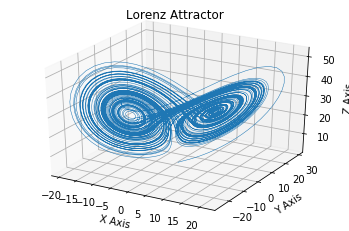

In [328]:
dt = 0.01
num_steps = 10000

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (1., 1., 1.)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    arr = [xs[i], ys[i], zs[i]]
    x_dot, y_dot, z_dot = lorenz(arr)
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)


# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

Lorenz escrito por mi: Odeint obliga a escribir de una forma determinada los argumentos de la EDO a calcular, así que mejor reescribirlo

In [332]:
def lorenz2(state, t):
    x, y, z = state  # saco las coordenadas del vector que me pasan
    b = 28.0
    a = 10.0
    c = 8.0/3.0
    return a * (y - x), x * (b - z) - y, x * y - c * z  # estan son las derivadas de cada coordenada

Empiezo probando para el punto inicial [1, 1, 1] y valores de tiempo de 0 a 40

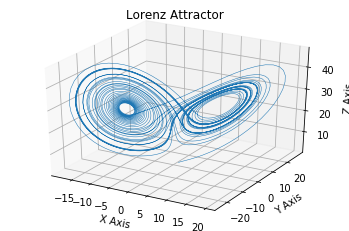

In [433]:
dt = 0.01
t_train = np.arange(0.0, 40.0, dt)
x0_train = [1.0, 1.0, 1.0]           
#odeint resuelve edos dado en el primer argumento la funcion que devuelve las ecuaciones dx/dt = ...
x_train = odeint(lorenz2, x0_train, t_train)

x_dot_train_measured = np.ones((t_train.size, 3))
for i in range(t_train.size):
    x_dot_train_measured[i] = lorenz2(x_train[i], t_train)
#x_dot_train_measured = np.array(
#    [lorenz2(x_train[i]) for i in range(t_train.size)]
#)

#ploteo los datos de entrenamiento:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

Intento buscar el máximo de cifras decimales y a partir del decimal número 52 rellena con ceros

In [331]:
# Fit the model, me creo el modelo dinámico 

poly_order = 4 #orden 3 y 4 es el que mejor lo hace
threshold = 0.2

#pysindy calcula las ecs que gobierna el movimiento
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold, normalize=True),
    feature_library=ps.PolynomialLibrary(degree=poly_order),#ps.FourierLibrary(n_frequencies=2),#
    feature_names=['x', 'y', 'z'],
    
    #fit_intercept=True,
)

#la doc dice que en t hay que poner el time step
model.fit(x_train, t=dt, x_dot=x_dot_train_measured, quiet=True)

model.equations(precision=52)
model.print(precision=52)
#model.coefficients()

x' = -10.0000000000000071054273576010018587112426757812500000 x + 10.0000000000000017763568394002504646778106689453125000 y
y' = 28.0000000000000248689957516035065054893493652343750000 x + -1.0000000000000053290705182007513940334320068359375000 y + -1.0000000000000004440892098500626161694526672363281250 x z
z' = -2.6666666666666638541016709496034309267997741699218750 z + 0.9999999999999996669330926124530378729104995727539062 x y


Ahora alimento el modelo con otro punto inicial pero mismo vector de tiempos, [5, 6, 27]

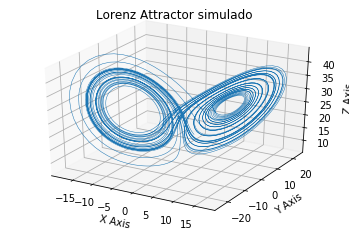

array([[ 5.        ,  6.        , 27.        ],
       [ 5.09503661,  6.00098977, 26.58835672],
       [ 5.18217678,  6.02367729, 26.19352801],
       ...,
       [ 1.6092213 ,  2.77785822, 16.71971067],
       [ 1.72816726,  2.94081187, 16.32682053],
       [ 1.85221626,  3.12285541, 15.95074145]])

In [317]:
#simulacion:
x0_sim = [5.0, 6.0, 27.0]
t_sim = np.arange(0.0, 40.0, dt)
x_sim = model.simulate(x0_sim, t_sim)
# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(x_sim[:, 0] , x_sim[:, 1], x_sim[:, 2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor simulado")

plt.show()
x_sim

Comparativa entre datos reales y simulados:

error medio cuadratico:
40.46577155434418
52.516162543256684
35.813642680013935
[[ 5.          6.         27.        ]
 [ 5.09503661  6.00098977 26.58835672]
 [ 5.18217678  6.02367729 26.19352801]
 ...
 [-2.03746387 -1.13094825 21.56406001]
 [-1.9570624  -1.25288472 21.02007741]
 [-1.89612463 -1.37917582 20.49193918]]


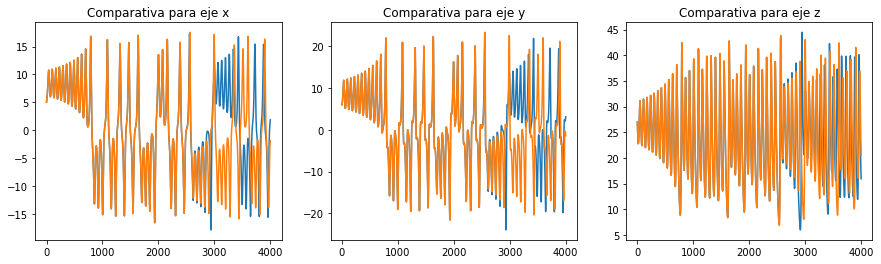

In [318]:
x_real = odeint(lorenz2, x0_sim, t_sim)
#calculo el error:
error = np.mean((x_real - x_sim) ** 2, axis=0)


print('error medio cuadratico:')
print(error[0])
print(error[1])
print(error[2])
fig = plt.figure(figsize=(15, 4))

ax = fig.add_subplot(131)
ax.plot(x_sim[:, 0] )
ax.plot(x_real[:, 0])
ax.set_title("Comparativa para eje x")

ax = fig.add_subplot(132)
ax.plot(x_sim[:, 1] )
ax.plot(x_real[:, 1])
ax.set_title("Comparativa para eje y")

ax = fig.add_subplot(133)
ax.plot(x_sim[:, 2] )
ax.plot(x_real[:, 2])
ax.set_title("Comparativa para eje z")

print(x_real)

Representación del atractor real:

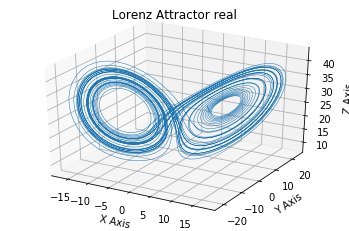

In [319]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(x_real[:, 0] , x_real[:, 1], x_real[:, 2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor real")

plt.show()

No se mejoran los resultados a pesar de incrementar el número de decimales, la razón es que el sistema es caótico para unos tiempos superiores al de liaponov

# Añadir términos a las ecuaciones de Lorenz

### Lorenz-Pablo (sin(xyz) y atan)

In [454]:
def lorenz_Pablo(state, t):
    x, y, z = state  # saco las coordenadas del vector que me pasan
    b = 28.0
    a = 10.0
    c = 8.0/3.0
    #print(math.sin(x*y*z))
    #print(math.atan(x))
    # estan son las derivadas de cada coordenada
    return a * (y - x), x * (b - z) - y + math.sin(y*z), x * y - c * z + math.atan(x) 

valores para cuando hago el odeint
valores para cuando hago la derivada


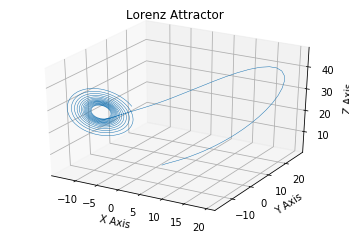

In [458]:
dt = 0.01
t_train = np.arange(0.0, 10.0, dt)
x0_train = [1.0, 1.0, 1.0]           
#odeint resuelve edos dado en el primer argumento la funcion que devuelve las ecuaciones dx/dt = ...
print("valores para cuando hago el odeint")
x_train = odeint(lorenz_Pablo, x0_train, t_train)

x_dot_train_measured = np.ones((t_train.size, 3))
print("valores para cuando hago la derivada")
#for i in range(t_train.size):
#    x_dot_train_measured[i] = lorenz_Pablo(x_train[i], t_train)


#ploteo los datos de entrenamiento:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show() #añadiendo el atan ya no parece el atractor de lorenz


In [422]:
# Fit the model, me creo el modelo dinámico 

poly_order = 5#orden 3 y 4 es el que mejor lo hace
threshold = 0.2

#pysindy calcula las ecs que gobierna el movimiento
model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=threshold, normalize=True),
    feature_library=ps.PolynomialLibrary(degree=poly_order),#ps.FourierLibrary(n_frequencies=2),#
    feature_names=['x', 'y', 'z'],
    
    #fit_intercept=True,
)

#la doc dice que en t hay que poner el time step
model.fit(x_train, t=dt, x_dot=x_dot_train_measured, quiet=True)

model.equations(precision=7)
model.print(precision=7)
#model.coefficients()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [397]:
#simulacion:
x0_sim = [5.0, 6.0, 27.0]
t_sim = np.arange(0.0, 40.0, dt)
x_sim = model.simulate(x0_sim, t_sim)
# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(x_sim[:, 0] , x_sim[:, 1], x_sim[:, 2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor simulado")

plt.show()
x_sim

NotFittedError: This SINDy instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.